In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## above is biolerplate

In [5]:
# utility function 
# to compare with manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
# the dimensionality of the character embedding vectors
n_embd = 10 
# the number of neurons in the hidden layer of the MLP
n_hidden = 64 

g = torch.Generator().manual_seed(2147483647) 
C  = torch.randn((vocab_size, n_embd),            generator=g)


# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 is useless here because of BN
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 



# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1




# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# initializating many of these parameters in non-standard ways to avoid trouble later (e.g. all zeros could mask an incorrect
# implementation of the backward pass).

parameters = [C, W1, b1, W2, b2, bngain, bnbias]


# number of parameters in total
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

# embedding
emb = C[Xb] 
# concatenate the vectors
embcat = emb.view(emb.shape[0], -1) 

# Linear layer 1
# hidden layer pre-activation
hprebn = embcat @ W1 + b1 



# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias


# Non-linearity
# still part of the hidden layer
h = torch.tanh(hpreact) 


# Linear layer 2
# output layer
logits = h @ W2 + b2 

# spelling out the cross entropy loss
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
# subtract max for numerical stability
norm_logits = logits - logit_maxes 


counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3540, grad_fn=<NegBackward0>)

# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

In [9]:
# dlogprobs.shape
# dlogprobs[:10]

In [10]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [11]:
# dlogprobs[range(n), Yb].shape

In [12]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0 / probs) * dlogprobs

In [13]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [14]:

# dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
# dcounts = counts_sum_inv * dprobs
# dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
# dcounts += torch.ones_like(counts) * dcounts_sum
# dnorm_logits = counts * dcounts
# dlogits = dnorm_logits.clone()
# dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
# dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

In [15]:
# dh, dh.shape

In [16]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes


dh = dlogits @ W2.T  #make the shapes work out

# da * dd
# dlogits and multiply

# dlogits
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)


dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
# dC = torch.zeros_like(C)

In [17]:
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

## a11, a12
## a21, a22
#### ---> b1  b2, where:
#### b1 = 1/(n-1)*(a11 + a21)
#### b2 = 1/(n-1)((a12 + a22)

In [18]:
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

## Summary


In [36]:
#forward pass: emb = C[Xb]

emb.shape, C.shape, Xb.shape

# There are integers in side C, which integer we wan to to use and package them into the sensor. 

# Now, we have to route the gradient, which row of C does the embeddings come from. So that we can undo the
# indexing. 



(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))


# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out


In [19]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()


In [20]:
# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.353985071182251 diff: 0.0


In [21]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) 

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [22]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [23]:
F.softmax(logits, 1)[:2]

tensor([[0.0667, 0.0814, 0.0186, 0.0526, 0.0199, 0.0854, 0.0238, 0.0356, 0.0178,
         0.0312, 0.0345, 0.0330, 0.0374, 0.0278, 0.0367, 0.0135, 0.0095, 0.0205,
         0.0160, 0.0574, 0.0499, 0.0224, 0.0243, 0.0724, 0.0616, 0.0267, 0.0234],
        [0.0518, 0.0554, 0.0914, 0.0572, 0.0358, 0.0360, 0.0175, 0.0414, 0.0203,
         0.0243, 0.0517, 0.0410, 0.0461, 0.0258, 0.0445, 0.0371, 0.0290, 0.0180,
         0.0230, 0.0388, 0.0202, 0.0227, 0.0141, 0.0680, 0.0257, 0.0362, 0.0270]],
       grad_fn=<SliceBackward0>)

In [24]:
dlogits[0] * n

tensor([ 0.0667,  0.0814,  0.0186,  0.0526,  0.0199,  0.0854,  0.0238,  0.0356,
        -0.9822,  0.0312,  0.0345,  0.0330,  0.0374,  0.0278,  0.0367,  0.0135,
         0.0095,  0.0205,  0.0160,  0.0574,  0.0499,  0.0224,  0.0243,  0.0724,
         0.0616,  0.0267,  0.0234], grad_fn=<MulBackward0>)

In [25]:
dlogits[0].sum()

tensor(1.1642e-09, grad_fn=<SumBackward0>)

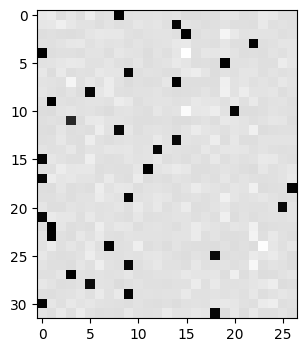

In [26]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [27]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out


In [28]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [30]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [33]:
dhprebn.shape, dhprebn

(torch.Size([32, 64]),
 tensor([[-3.3036e-04, -7.7362e-04,  1.2221e-03,  ..., -2.2994e-04,
          -8.6389e-04, -9.1991e-04],
         [-3.0579e-05,  1.3432e-03,  5.1699e-04,  ...,  5.5792e-04,
          -1.7807e-03, -2.4296e-03],
         [ 2.2629e-04,  2.1589e-03,  6.8046e-04,  ...,  2.6955e-03,
          -1.5441e-04,  6.4322e-04],
         ...,
         [-9.5283e-04,  1.4971e-03, -1.3172e-03,  ..., -2.2479e-03,
          -1.5713e-03, -1.4500e-03],
         [-4.6439e-04,  3.2566e-04, -1.3036e-03,  ...,  1.9837e-04,
           3.1971e-04,  8.7024e-04],
         [-7.6897e-05,  3.2394e-03,  2.6904e-03,  ..., -7.7238e-04,
           5.4821e-04,  7.5359e-04]], grad_fn=<MulBackward0>))

In [31]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [29]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

In [35]:
# the dimentionality of the character embedding vectors
n_embd = 10 
# the number of neurons in the hidden layer of the MLP
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)


# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1


# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1


# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency 
# when your backward pass is written (TODO)
with torch.no_grad():

  # optimization
  for i in range(max_steps):

    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] 
    embcat = emb.view(emb.shape[0], -1) 
    
    # Linear layer
    # hidden layer pre-activation
    hprebn = embcat @ W1 + b1 
    
    # BatchNorm layer
    # ---------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    
    # ------------------------------
    # Non-linearity
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
        
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    
    # tanh
    dhpreact = (1.0 - h**2) * dh
    
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[k,j]
            dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad 
    # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


12297
      0/ 200000: 3.7846
    100/ 200000: 2.3285
    200/ 200000: 2.8552
    300/ 200000: 2.5941
    400/ 200000: 2.5171
    500/ 200000: 2.7967
    600/ 200000: 2.4346
    700/ 200000: 2.3966
    800/ 200000: 2.3931
    900/ 200000: 2.1684
   1000/ 200000: 2.2452
   1100/ 200000: 2.2398
   1200/ 200000: 2.7076
   1300/ 200000: 2.7515
   1400/ 200000: 2.3485
   1500/ 200000: 2.4486
   1600/ 200000: 2.5803
   1700/ 200000: 2.3613
   1800/ 200000: 2.3415
   1900/ 200000: 2.3779
   2000/ 200000: 2.3014
   2100/ 200000: 2.4289
   2200/ 200000: 1.9612
   2300/ 200000: 2.4265
   2400/ 200000: 2.8966
   2500/ 200000: 2.3695
   2600/ 200000: 2.3160
   2700/ 200000: 2.1737
   2800/ 200000: 2.1881
   2900/ 200000: 2.2890
   3000/ 200000: 2.2213
   3100/ 200000: 2.6342
   3200/ 200000: 2.1341
   3300/ 200000: 2.2326
   3400/ 200000: 2.2510
   3500/ 200000: 2.4006
   3600/ 200000: 2.1220
   3700/ 200000: 2.2014
   3800/ 200000: 2.4010
   3900/ 200000: 2.3624
   4000/ 200000: 2.1944
   4100/ 2

  34200/ 200000: 2.1048
  34300/ 200000: 2.1510
  34400/ 200000: 2.4536
  34500/ 200000: 2.3423
  34600/ 200000: 2.4822
  34700/ 200000: 2.3057
  34800/ 200000: 2.0923
  34900/ 200000: 1.9027
  35000/ 200000: 2.3849
  35100/ 200000: 2.3362
  35200/ 200000: 2.5206
  35300/ 200000: 2.0135
  35400/ 200000: 2.6434
  35500/ 200000: 2.2733
  35600/ 200000: 2.0217
  35700/ 200000: 2.2535
  35800/ 200000: 2.1019
  35900/ 200000: 2.0256
  36000/ 200000: 2.1931
  36100/ 200000: 2.3359
  36200/ 200000: 2.1178
  36300/ 200000: 2.2772
  36400/ 200000: 2.1026
  36500/ 200000: 2.0325
  36600/ 200000: 2.2180
  36700/ 200000: 2.3011
  36800/ 200000: 2.0814
  36900/ 200000: 2.6424
  37000/ 200000: 2.0245
  37100/ 200000: 2.1142
  37200/ 200000: 2.4680
  37300/ 200000: 2.2867
  37400/ 200000: 2.2946
  37500/ 200000: 1.6378
  37600/ 200000: 2.3705
  37700/ 200000: 2.2492
  37800/ 200000: 1.9757
  37900/ 200000: 2.0964
  38000/ 200000: 2.6470
  38100/ 200000: 1.9777
  38200/ 200000: 2.0949
  38300/ 200000:

  68400/ 200000: 2.6331
  68500/ 200000: 1.9876
  68600/ 200000: 2.1975
  68700/ 200000: 2.2786
  68800/ 200000: 2.3742
  68900/ 200000: 2.2400
  69000/ 200000: 2.1203
  69100/ 200000: 1.9540
  69200/ 200000: 2.0505
  69300/ 200000: 2.1415
  69400/ 200000: 2.4405
  69500/ 200000: 2.2747
  69600/ 200000: 2.2517
  69700/ 200000: 2.1068
  69800/ 200000: 2.0899
  69900/ 200000: 2.1837
  70000/ 200000: 2.0057
  70100/ 200000: 2.6347
  70200/ 200000: 2.3201
  70300/ 200000: 2.4894
  70400/ 200000: 2.2092
  70500/ 200000: 2.2395
  70600/ 200000: 1.9107
  70700/ 200000: 2.7185
  70800/ 200000: 1.6477
  70900/ 200000: 1.6637
  71000/ 200000: 2.2256
  71100/ 200000: 2.3386
  71200/ 200000: 2.4687
  71300/ 200000: 2.0119
  71400/ 200000: 2.3510
  71500/ 200000: 2.1131
  71600/ 200000: 2.2221
  71700/ 200000: 1.8751
  71800/ 200000: 1.8228
  71900/ 200000: 2.3916
  72000/ 200000: 2.5478
  72100/ 200000: 2.1471
  72200/ 200000: 2.0937
  72300/ 200000: 2.4610
  72400/ 200000: 1.9859
  72500/ 200000:

 102600/ 200000: 2.0913
 102700/ 200000: 2.1816
 102800/ 200000: 2.5283
 102900/ 200000: 2.0085
 103000/ 200000: 2.1612
 103100/ 200000: 2.2091
 103200/ 200000: 2.3000
 103300/ 200000: 2.0070
 103400/ 200000: 2.2988
 103500/ 200000: 2.1439
 103600/ 200000: 1.9051
 103700/ 200000: 2.3110
 103800/ 200000: 2.5280
 103900/ 200000: 2.0731
 104000/ 200000: 2.2847
 104100/ 200000: 2.3257
 104200/ 200000: 2.0463
 104300/ 200000: 2.0709
 104400/ 200000: 2.0111
 104500/ 200000: 1.9491
 104600/ 200000: 2.8621
 104700/ 200000: 2.0824
 104800/ 200000: 1.9736
 104900/ 200000: 2.0452
 105000/ 200000: 1.9835
 105100/ 200000: 2.1710
 105200/ 200000: 2.1440
 105300/ 200000: 2.2510
 105400/ 200000: 1.8797
 105500/ 200000: 2.0458
 105600/ 200000: 2.0253
 105700/ 200000: 2.1690
 105800/ 200000: 2.2340
 105900/ 200000: 1.9634
 106000/ 200000: 2.2926
 106100/ 200000: 1.8802
 106200/ 200000: 1.8477
 106300/ 200000: 2.1778
 106400/ 200000: 2.3443
 106500/ 200000: 2.2146
 106600/ 200000: 2.0521
 106700/ 200000:

 136800/ 200000: 1.6282
 136900/ 200000: 1.8012
 137000/ 200000: 2.0187
 137100/ 200000: 1.8050
 137200/ 200000: 2.0770
 137300/ 200000: 2.3701
 137400/ 200000: 2.0706
 137500/ 200000: 2.1706
 137600/ 200000: 2.4072
 137700/ 200000: 2.0043
 137800/ 200000: 2.3084
 137900/ 200000: 2.2099
 138000/ 200000: 2.1197
 138100/ 200000: 2.4568
 138200/ 200000: 2.3653
 138300/ 200000: 2.1701
 138400/ 200000: 2.2289
 138500/ 200000: 2.0713
 138600/ 200000: 2.3906
 138700/ 200000: 2.2139
 138800/ 200000: 2.0395
 138900/ 200000: 2.6464
 139000/ 200000: 1.9552
 139100/ 200000: 2.0621
 139200/ 200000: 1.9938
 139300/ 200000: 2.0985
 139400/ 200000: 2.2922
 139500/ 200000: 1.8669
 139600/ 200000: 2.0508
 139700/ 200000: 2.0652
 139800/ 200000: 2.0805
 139900/ 200000: 2.0594
 140000/ 200000: 2.3167
 140100/ 200000: 2.3887
 140200/ 200000: 1.7803
 140300/ 200000: 1.9175
 140400/ 200000: 1.9439
 140500/ 200000: 2.0538
 140600/ 200000: 1.9058
 140700/ 200000: 2.2302
 140800/ 200000: 2.1419
 140900/ 200000:

 171000/ 200000: 2.2050
 171100/ 200000: 2.0940
 171200/ 200000: 2.0161
 171300/ 200000: 2.1374
 171400/ 200000: 2.2145
 171500/ 200000: 2.1726
 171600/ 200000: 2.0249
 171700/ 200000: 1.9889
 171800/ 200000: 2.0374
 171900/ 200000: 2.0377
 172000/ 200000: 2.0357
 172100/ 200000: 1.9167
 172200/ 200000: 1.9108
 172300/ 200000: 2.0931
 172400/ 200000: 2.4038
 172500/ 200000: 2.2631
 172600/ 200000: 2.2215
 172700/ 200000: 1.9857
 172800/ 200000: 1.9047
 172900/ 200000: 2.0598
 173000/ 200000: 2.0732
 173100/ 200000: 2.1613
 173200/ 200000: 2.2074
 173300/ 200000: 1.9556
 173400/ 200000: 1.9040
 173500/ 200000: 2.2649
 173600/ 200000: 2.0394
 173700/ 200000: 2.1798
 173800/ 200000: 2.0458
 173900/ 200000: 1.8743
 174000/ 200000: 2.4218
 174100/ 200000: 2.0606
 174200/ 200000: 2.2320
 174300/ 200000: 2.3616
 174400/ 200000: 2.1734
 174500/ 200000: 2.3254
 174600/ 200000: 2.1821
 174700/ 200000: 1.9008
 174800/ 200000: 2.3697
 174900/ 200000: 2.2621
 175000/ 200000: 2.0366
 175100/ 200000:

In [39]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [41]:
# checking your gradients
# for p,g in zip(parameters, grads):
#     cmp(str(tuple(p.shape)), g, p)

In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071593999862671
val 2.109997510910034


In [43]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass:
      # Embedding
        emb = C[torch.tensor([context])] 
        # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) 
        # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) 
        # (N, n_hidden)
        logits = h @ W2 + b2
        # (N, vocab_size)

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
ndon.
alee.
thruthadrie.
cailee.
melin.
shi.
jenleigh.
sana.
arleigh.
malaia.
noshubergahimie.
trick.
welle.
joseus.
kuma.
geder.
yarul.
